# XAI 기본 기법

#### 1. Decision Tree

#### 2. Feature Importance


XAI 시각화와는 다르다. XAI의 핵심은 해석 가능성이다.

해석 가능성은 왜 해당 모델을 신뢰해야 하는지, 왜 특정 결정을 했는지에 관한 근거를 찾고,
어떤 결과가 예상되는지 판단하는 과정이다.

XAI는 대리 분석(Surrogate Analysis), 부분 의존성 플롯(Partial Dependence Plots, PDPs), 유사도 분석(Similarity Measure), 피처 중요도(Feature Importance) 등의 기법으로 데이터와 모델을 설명한다.

 
 
# 의사 결정 트리

의사 결정 트리(Decision Tree)는 질문을 던지고 답을 하는 과정을 연쇄적으로 반복해 집단을 분류하거나 예측하는 분석 방법이다.

연구자가 분석 과정을 쉽게 이해하고 설명할 수 있다는 장점이 있다.


# 피처 중요도 구하기

데이터의 피처가 알고리즘의 정확한 분류에 얼마나 큰 영향을 미치는지 분석하는 기법이다.

특정 피처의 값을 임의의 값으로 치환했을 때 원래 데이터보다 예측 에러가 얼마나 더 커지는가를 측정하는 것이다.


# 부분 의존성 플롯 그리기

피처의 수치를 선형적으로 변형하면서 알고리즘 해석 능력이 얼마나 증가하고 감소하는지를 관찰하는 방식이다.

피처의 값이 변할 때 모델에 미치는 영향을 가시적으로 이해할 수 있다.

# 실습 1: 피마 인디언 당뇨병 결정 모델

Pima Indian diabetes set

미국 애리조나 주의 피마 인디언을 대상으로 당뇨병 진단 데이터 셋

Feature

1. 임신 횟수
2. 경구 포도당 내성 검사에서 형장 포도당 농도
3. 확장기 혈압
4. 삼두근 피부 두께
5. 인슐린 혈청 저항성
6. 체질량 지수(BMI)
7. 당뇨병 병력 함수
8. 나이

In [42]:
from numpy import loadtxt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# 데이터 로드

dataset = loadtxt('pima-indians-diabetes.csv', delimiter=',')
# X와 Y로 데이터 분리
X = dataset[:, 0:8]
y = dataset[:,8]

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=7)

# 학습 데이터로 모델을 학습시키기
model = XGBClassifier()
model.fit(x_train, y_train)

# 예측하기
y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]

# 평가하기
accuracy = accuracy_score(y_test, predictions)
print('Accuracy: %.2f%%'%(accuracy * 100.0))

Accuracy: 81.17%


In [29]:
value = [1, 161, 72, 35, 0, 28.1, 0.527, 20]

l = model.predict_proba(value)
print('No diabetes: {:.2%}\nYes diabetes: {:.2%}'.format(l[0][0], l[0][1]))

No diabetes: 69.09%
Yes diabetes: 30.91%


81.17%의 정확도가 부족하다고 느끼는 데이터 과학자도 있을 수 있다.

그런 사람들은 파라미터 튜닝으로 테스트 정확도를 올리려고 한다.

그렇지만 파라미터 튜닝만으로는 위 모델이 어떤 원리로 환자를 당뇨라고 진단하는지 알 수 없다.

XAI 기법을 통해 이 모델의 신뢰성을 높여야 한다.

환자에게 진단 결과를 설명할 때 도움을 주기도 하고, 환자가 스스로 진단 결과를 해석하려고 할 때도 큰 도움이 된다.

**XAI는 튜닝을 하거나 새로운 피처를 고안할 때도 새로운 통찰을 준다.**

__파라미터와 가중치로 복잡하게 얽혀 있는 블랙박스를 이해함으로써 '생각의 틀을 깨는(Think outside the box)'사고를 할 수 있게 된다.__

# 의사 결정 트리 시각화

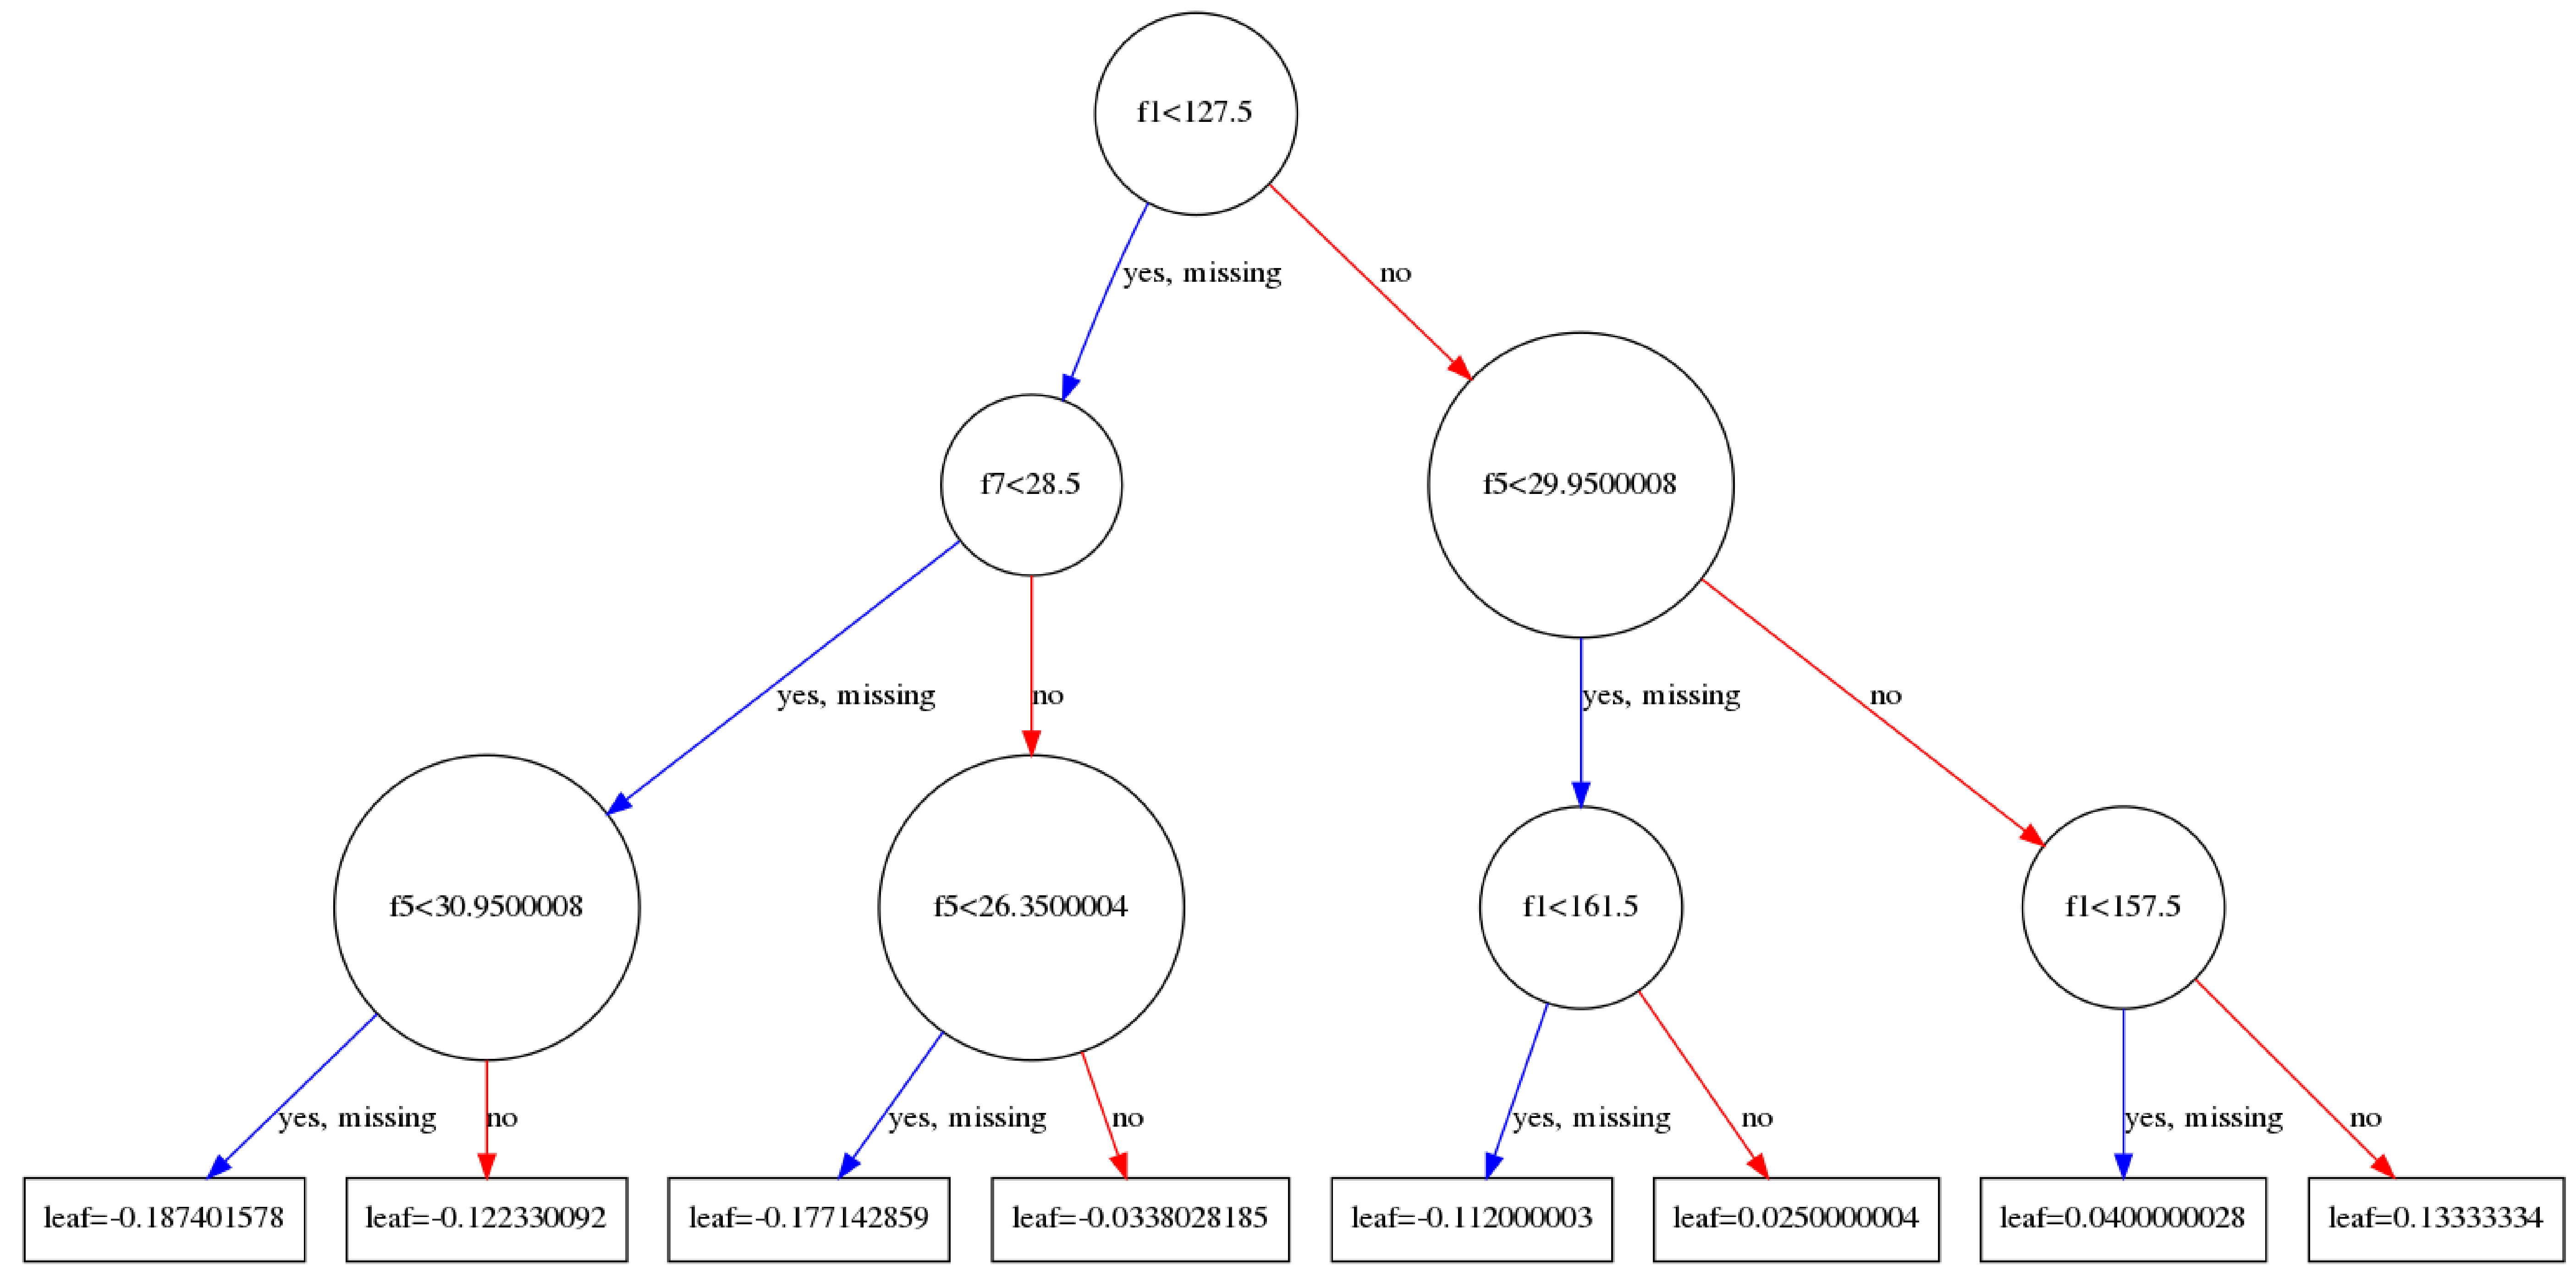

In [31]:
%matplotlib inline
import os 
# graphviz 경로 설정하기
#os.environ["PATH"] += (os.pathsep + 'C')

from xgboost import plot_tree
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 100, 200

# 의사 결정 트리 시각화
plot_tree(model)
plt.show()

앞서 사용한 데이터인 [1, 161, 72, 35, 0, 28.1, 0.527, 20]에서

Glucose가 161이고 BMI 28.1이므로 종단 노드는 leaf = -0.112000003라는 값이 출력된다.

이 종단 노드의 값은 로지스틱 함수 확률값으로 진단한다.

In [32]:
import numpy as np
result = 1.0/(1 + np.exp(-(-0.112000003)))
result

0.47202923191677365

이 환자는 47.2%로 당뇨병을 앓고 있지 않다고 진단한다.

# 피처 중요도 구분하기

피셔, 루딘, 도미니치의 피처 중요도 계산 방법을 사용한다.

특정 피처마다 한 번씩 순회하면서 모델을 만들고 에러를 측정하며 FI를 조정한다.

이때 중요한 점은 피처들 모두가 서로에게 상호 의존성이 약해야 한다는 것이다.

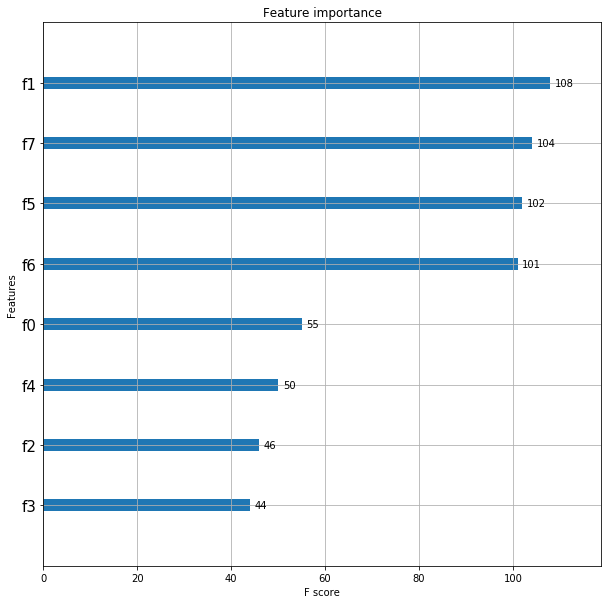

'\nf1: Glucose\nf7: Age\nf5: BMI\nf6: DiabetesPredigreeFunction\nf0: pregnancies\nf4: Insulin\nf2: BloodPressure\nf1: SkinThickness\n'

In [35]:
from xgboost import plot_importance

rcParams['figure.figsize'] = 10,10

plot_importance(model)

plt.yticks(fontsize=15)
plt.show()
'''
f1: Glucose
f7: Age
f5: BMI
f6: DiabetesPredigreeFunction
f0: pregnancies
f4: Insulin
f2: BloodPressure
f3: SkinThickness
'''

# 부분 의존성 플롯 그리기

피처의 수치 변화에 따라 모델에 기여하는 정도가 어떻게 달라지는지 확인할 수 있는 기법이다.

궁금한 피처가 모델에 긍정적인/부정적인 영향을 미치는지 파악하게 도울뿐만 아니라,

특정 피처에 대해 여유분을 함께 표시함으로써 피처 간 독립을 보장하지 못하는 환경에서 

어느 정도 모델에 오차가 있을 수 있는지를 확인할 수 있게 해준다.

pdpbox를 사용해 특정 피처에 대한 목표 플롯(Target plots)을 그려본다.

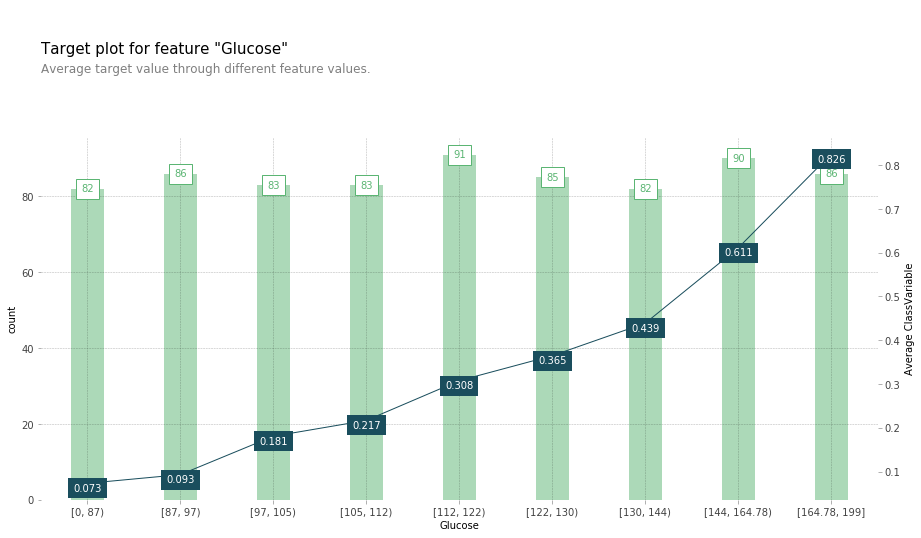

In [70]:
from pdpbox import info_plots
import pandas as pd

df = pd.DataFrame(dataset, columns=['pregnancies','Glucose','BloodPressure',
                                    'SkinThickness','Insulin','BMI',
                                    'DiabetesPredigreeFunction','Age','ClassVariable'])

pima_data = df
pima_features = df.columns[:8]
pima_target = df.columns[8]

fig, axes, summary_df = info_plots.target_plot(df=pima_data, 
                                               feature='Glucose', 
                                               feature_name='Glucose',
                                               target=pima_target)

이 기법은 모델을 파라미터로 받지 않는다.

학습 데이터를 철저하게 분석해서 모델이 어떻게 학습할 것인지 예상하는 XAI기법이다.

특정 데이터가 편향돼 있고, 그 데이터에 맞춰 결론이 왜곡돼 있다면 

모델을 뜯어보지 않아도 어떤 편향으로 모델이 학습될지 파악할 수 있다.

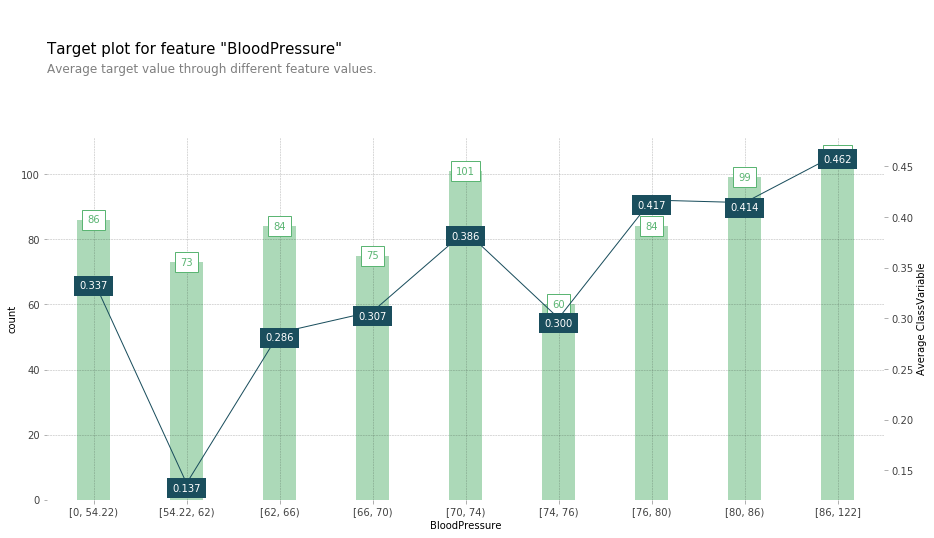

In [45]:
fig, axes, summary_df = info_plots.target_plot(df=pima_data, 
                                               feature='BloodPressure', 
                                               feature_name='BloodPressure',
                                               target=pima_target)

데이터와 실제 모델을 결합해 두 결과가 일치하는지 확인한다.

이 기법은 예측 분포 플롯(prediction distribution plot)이라고 부른다.

In [52]:
y = df["ClassVariable"]
df.drop('ClassVariable', axis=1, inplace=True)
X = df
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=7)

# 학습 데이터로 모델을 학습시키기
model = XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

/root/anaconda3/envs/xai/lib/python3.7/site-packages/pdpbox/info_plots.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  info_df['actual_prediction'] = prediction[:, 1]


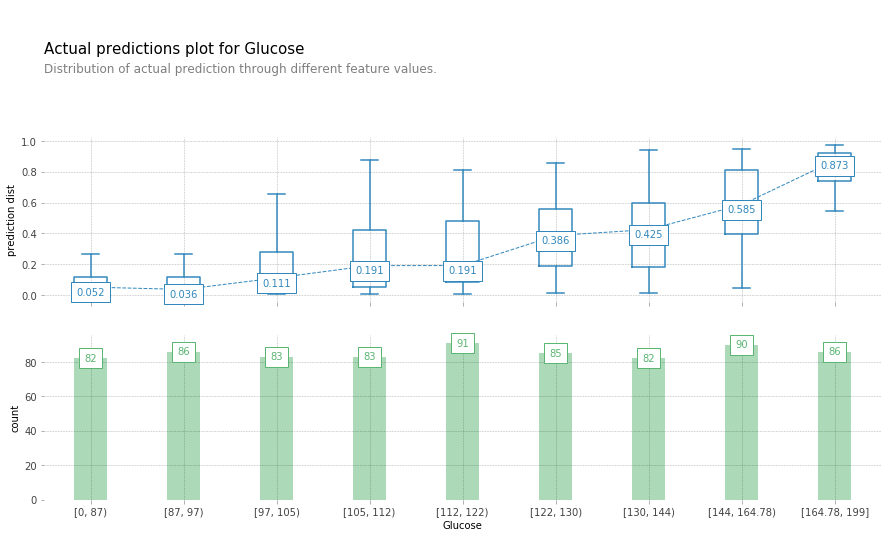

In [53]:
fig, axes, summary_df = info_plots.actual_plot(model = model,
                                               X=pima_data[pima_features],
                                               feature='Glucose', 
                                               feature_name='Glucose',
                                               predict_kwds={})

특정 피처에 대해 모델 부분 의존성 플롯을 그린다.

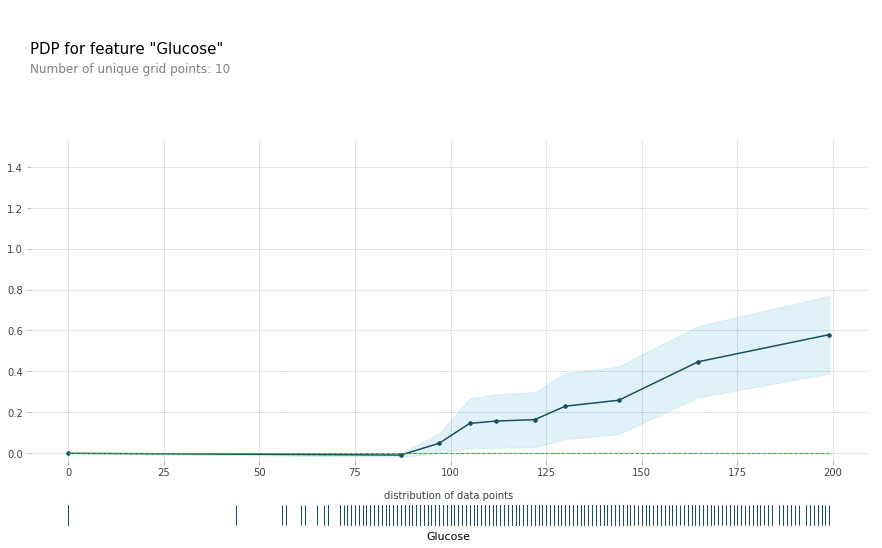

In [67]:
from pdpbox.pdp import pdp_isolate, pdp_plot
pdp_gc = pdp_isolate(model = model,
                    dataset=pima_data,
                    model_features = pima_features,
                    feature = "Glucose")

fig, axes = pdp_plot(pdp_gc,
                    "Glucose",
                    plot_lines = False,
                    frac_to_plot=0.5,
                    plot_pts_dist=True)

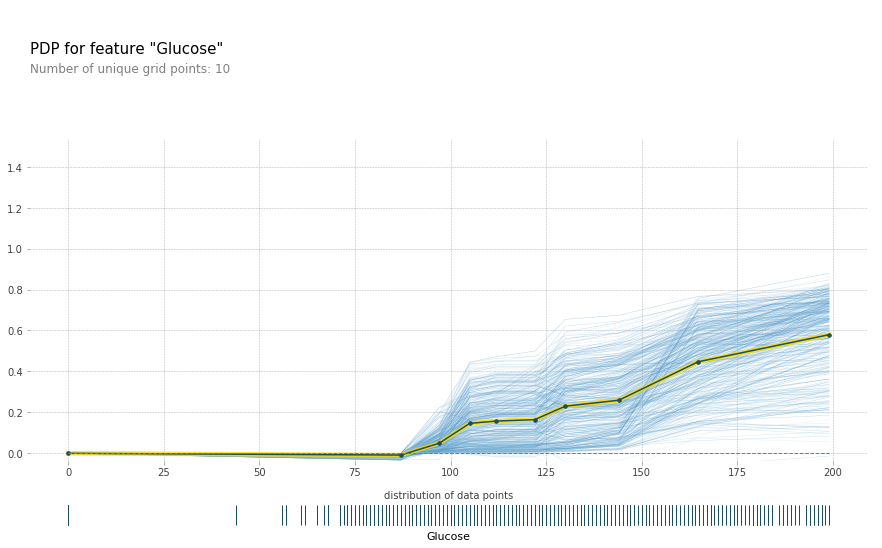

In [78]:
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
pdp_gc = pdp_isolate(model = model,
                    dataset=pima_data,
                    model_features = pima_features,
                    feature = "Glucose")

fig, axes = pdp_plot(pdp_gc,
                    "Glucose",
                    plot_lines = True,
                    frac_to_plot=0.5,
                    plot_pts_dist=True)

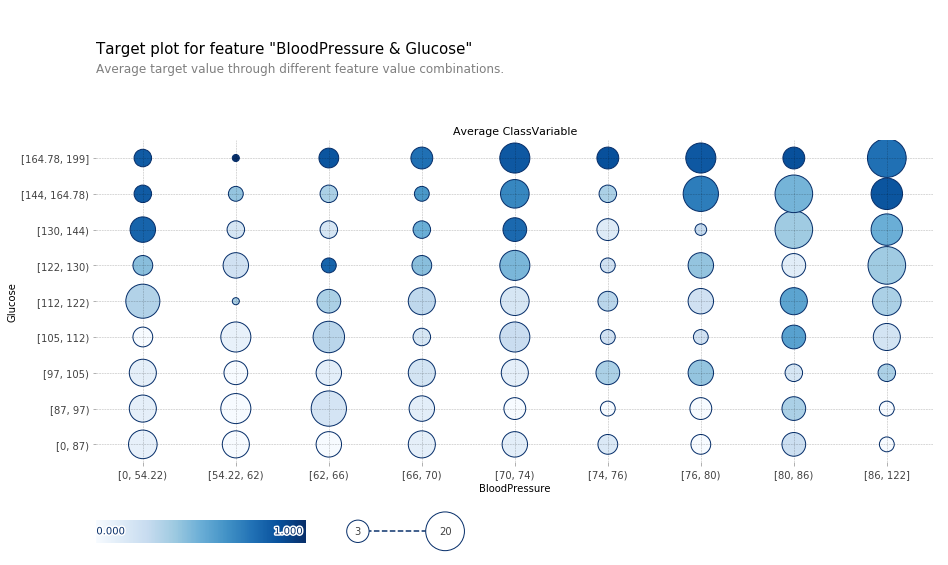

In [71]:
# 혁압과 GTT 테스트 데이터 두 피처에 대해 목표 플롯을 그리는 코드

fig, axes, summary_df = info_plots.target_plot_interact(df = pima_data,
                                                       features=["BloodPressure", "Glucose"],
                                                       feature_names=["BloodPressure", "Glucose"],
                                                       target = pima_target)

원의 크기가 작을수록 사례가 적어지고, 원이 커질수록 사례가 많아진다.

당뇨병 진단은 원의 색으로 구분한다.

원 안의 색이 진할수록 당뇨병 진단 가능성이 높아진다.

위 결과를 보면 혈압은 GTT 테스트 결과보다 약한 상관관계를 가진다.

과학적 사실과 위 결과를 비교하면 상식대로 데이터가 분포돼 있는지 시각적으로 확인할 수 있다.

피마 인디언 데이터와 의학적 사실이 어느 정도 합치한다는 것을 확인할 수 있다.

TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'

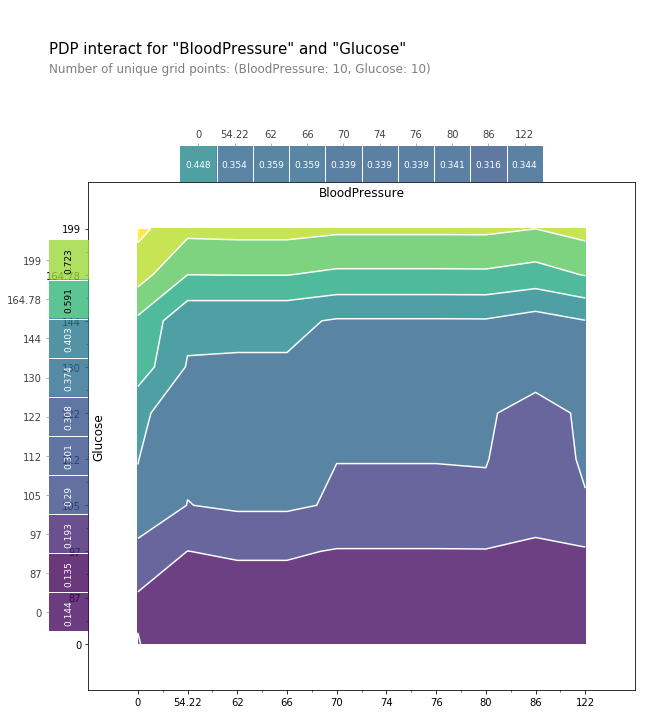

In [83]:
# 혈압과 GTT 테스트 데이터로 모델에 대한 부분 의존성 플롯을 그리는 코드

pdp_interaction = pdp_interact(model = model,
                              dataset = pima_data,
                              model_features = pima_features,
                              features = ['BloodPressure', 'Glucose'])
fig, axes = pdp_interact_plot(pdp_interact_out = pdp_interaction,
                             feature_names=['BloodPressure', 'Glucose'],
                             plot_type = 'contour',
                             x_quantile = True,
                             plot_pdp=True)

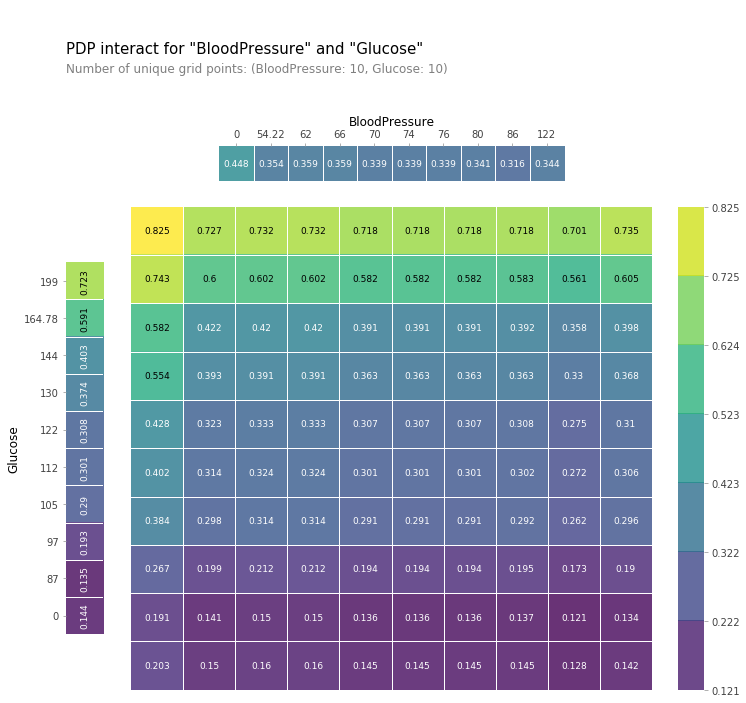

In [84]:
# 혈압과 GTT 테스트 데이터로 모델에 대한 부분 의존성 플롯을 그리는 코드

pdp_interaction = pdp_interact(model = model,
                              dataset = pima_data,
                              model_features = pima_features,
                              features = ['BloodPressure', 'Glucose'])
fig, axes = pdp_interact_plot(pdp_interact_out = pdp_interaction,
                             feature_names=['BloodPressure', 'Glucose'],
                             plot_type = 'grid',
                             x_quantile = True,
                             plot_pdp=True)

부분 의존성 차트는 모델이 혈압보다는 GTT 테스트 피처의 크기 변화에 훨씬 더 민감하게 당뇨병 진단을 내리는 것으로 해석된다.

이 뜻은 혈압이 당뇨병 진단에 크게 도움이 안 된다고 해석할 수 있다는 것으로 의학적 상식과 크게 일치하지 않는다는 것을 의미한다.

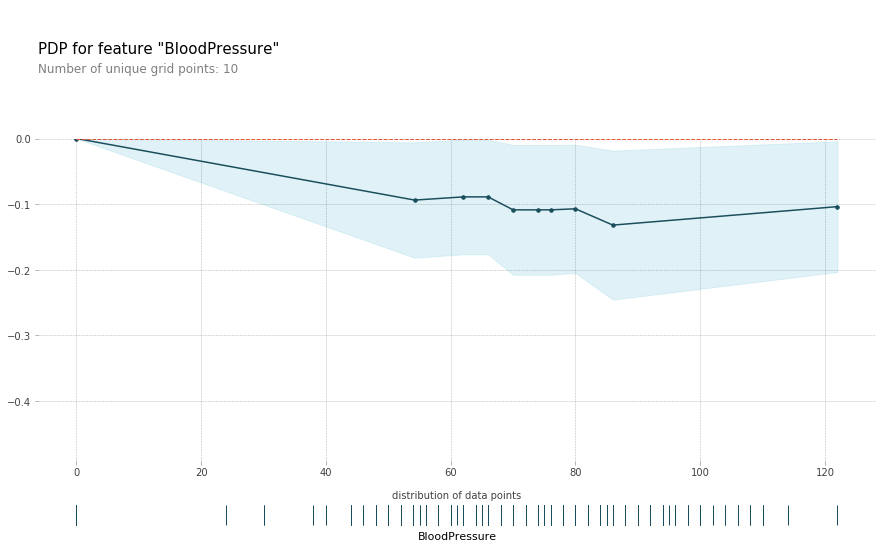

In [86]:
# 혈압 정보를 계산하는 코드

pdp_bp = pdp_isolate(model = model,
                    dataset = pima_data,
                    model_features = pima_features,
                    feature='BloodPressure')

# 혈압에 대한 PDP 정보를 플롯

fig, axes = pdp_plot(pdp_bp,
                    'BloodPressure',
                    plot_lines=False,
                    frac_to_plot=0.5,
                    plot_pts_dist=True)

위 결과에 의하면 모델은 혈압이 측정될 때마다 당뇨병 진단에 음의 영향력을 발휘한다.

이것은 목표 플롯의 결과와 명백하게 다르다.

목표 플롯으로 데이터를 분석했을 때는 당뇨병 진단 가능성이 혈압에 비례해 높아졌기 때문이다.

# 해석 결과가 상충한다면 무엇이 옳은 해석일까?

앞서 피처 중요도는 관심 있는 피처가 독립적일 때 잘 계산되며, 중요도는 측정 가능하다고 배웠다.

그러나 피처 중요도에는 방향이 없으며, 피처 계층에 따라 모델에 미치는 영향을 확인할 수 없고, 

피처 간 의존성이 조금이라도 존재할 경우 결과를 신뢰할 수 없다고 했다.

이러한 한계를 극복하고자 부분 의존성 플롯이 등장했다.

피처가 의존적일 때도 계산이 가능하다.

<br><br><br>

의학적 사실로는 당뇨병은 70%정도의 확률로 고혈압을 동반한다.

그러나 사용한 데이터는 의학적인 고혈압을 표시할 수 없었다. 

모델은 정상기 혈압을 학습했으므로 혈압 피처가 당뇨병 진단에 음의 영향력을 발휘했다고 해석할 수 있다.

PDP를 그려서 알게 된 혈압과 당뇨병 진단에 대한 관계는 위와 같은 현상을 해석하는 합리적인 근거가 된다.

<br><br><br>

이 혼란은 우리의 해석에서 발생한다.

지금까지 사용한 피처 중요도, 목표 플롯, 부분 의존성 플롯은 데이터를 해석하는 기법이다.

데이터는 배신하지 않지만 데이터를 해석하는 방법은 얼마든지 배신할 수 있다.

알고리즘이 어떤 데이터를 해석하는지, 그 결과가 어느 한계까지 유효한지에 대해 정확하게 인식하고 있지 않으면

과대 해석의 오류에 빠지기 쉽다.



# 모델 튜닝하기

이전 모델에서는 3가지의 피처만 가지고도 81.17%의 정확도를 보였다.

질병 진단과 같이 정확도가 중시되는 모델에서는 0.1%의 성능 향상이 매우 소중하다.

그러나 남은 피처를 사용하지 않았다는 점과 

민감도(sensitivity), 정밀성(precision), 특이성(specialty), 낙제율(fallout)도 중요하게 여겨야 한다.

이를 만족시키기 위해서 새롭게 모델을 조정한다.

In [87]:
# GridSearchCV를 통해 당뇨병 진단 모델의 최적 하이퍼파라미터를 찾는 코드

import numpy as np
from sklearn.model_selection import GridSearchCV

cv_params = {
    'max_depth': np.arange(1,6,1),#[1,2,3,4,5]
}

fix_params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
}

csv = GridSearchCV(XGBClassifier(**fix_params),
                  cv_params,
                  scoring = 'precision',
                  cv = 5,
                  n_jobs=5)
csv.fit(x_train, y_train)

print(csv.best_params_)

# 테스트 데이터 예측하기

y_pred = csv.predict(x_test)
predictions = [round(value) for value in y_pred]

# 정확도 평가

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%"%(accuracy * 100.0))

{'max_depth': 1}
Accuracy: 77.92%


In [89]:
# GridSearchCV를 사용해 max_depth, learning_rate, n_estimators 파라미터값 변화에 대한 최적의 모델을 찾는 코드

import numpy as np
from sklearn.model_selection import GridSearchCV

cv_params = {
    'max_depth': np.arange(1,6,1),#[1,2,3,4,5]
    'learning_rate': np.arange(0.05,0.6,0.05),
    'n_estimators': np.arange(50,300,50),
}

fix_params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
}

csv = GridSearchCV(XGBClassifier(**fix_params),
                  cv_params,
                  scoring = 'precision',
                  cv = 5,
                  n_jobs=-1)
csv.fit(x_train, y_train)

print(csv.best_params_)

# 테스트 데이터 예측하기

y_pred = csv.predict(x_test)
predictions = [round(value) for value in y_pred]

# 정확도 평가

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%"%(accuracy * 100.0))

{'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 50}
Accuracy: 73.38%


Accuracy: 84.42%


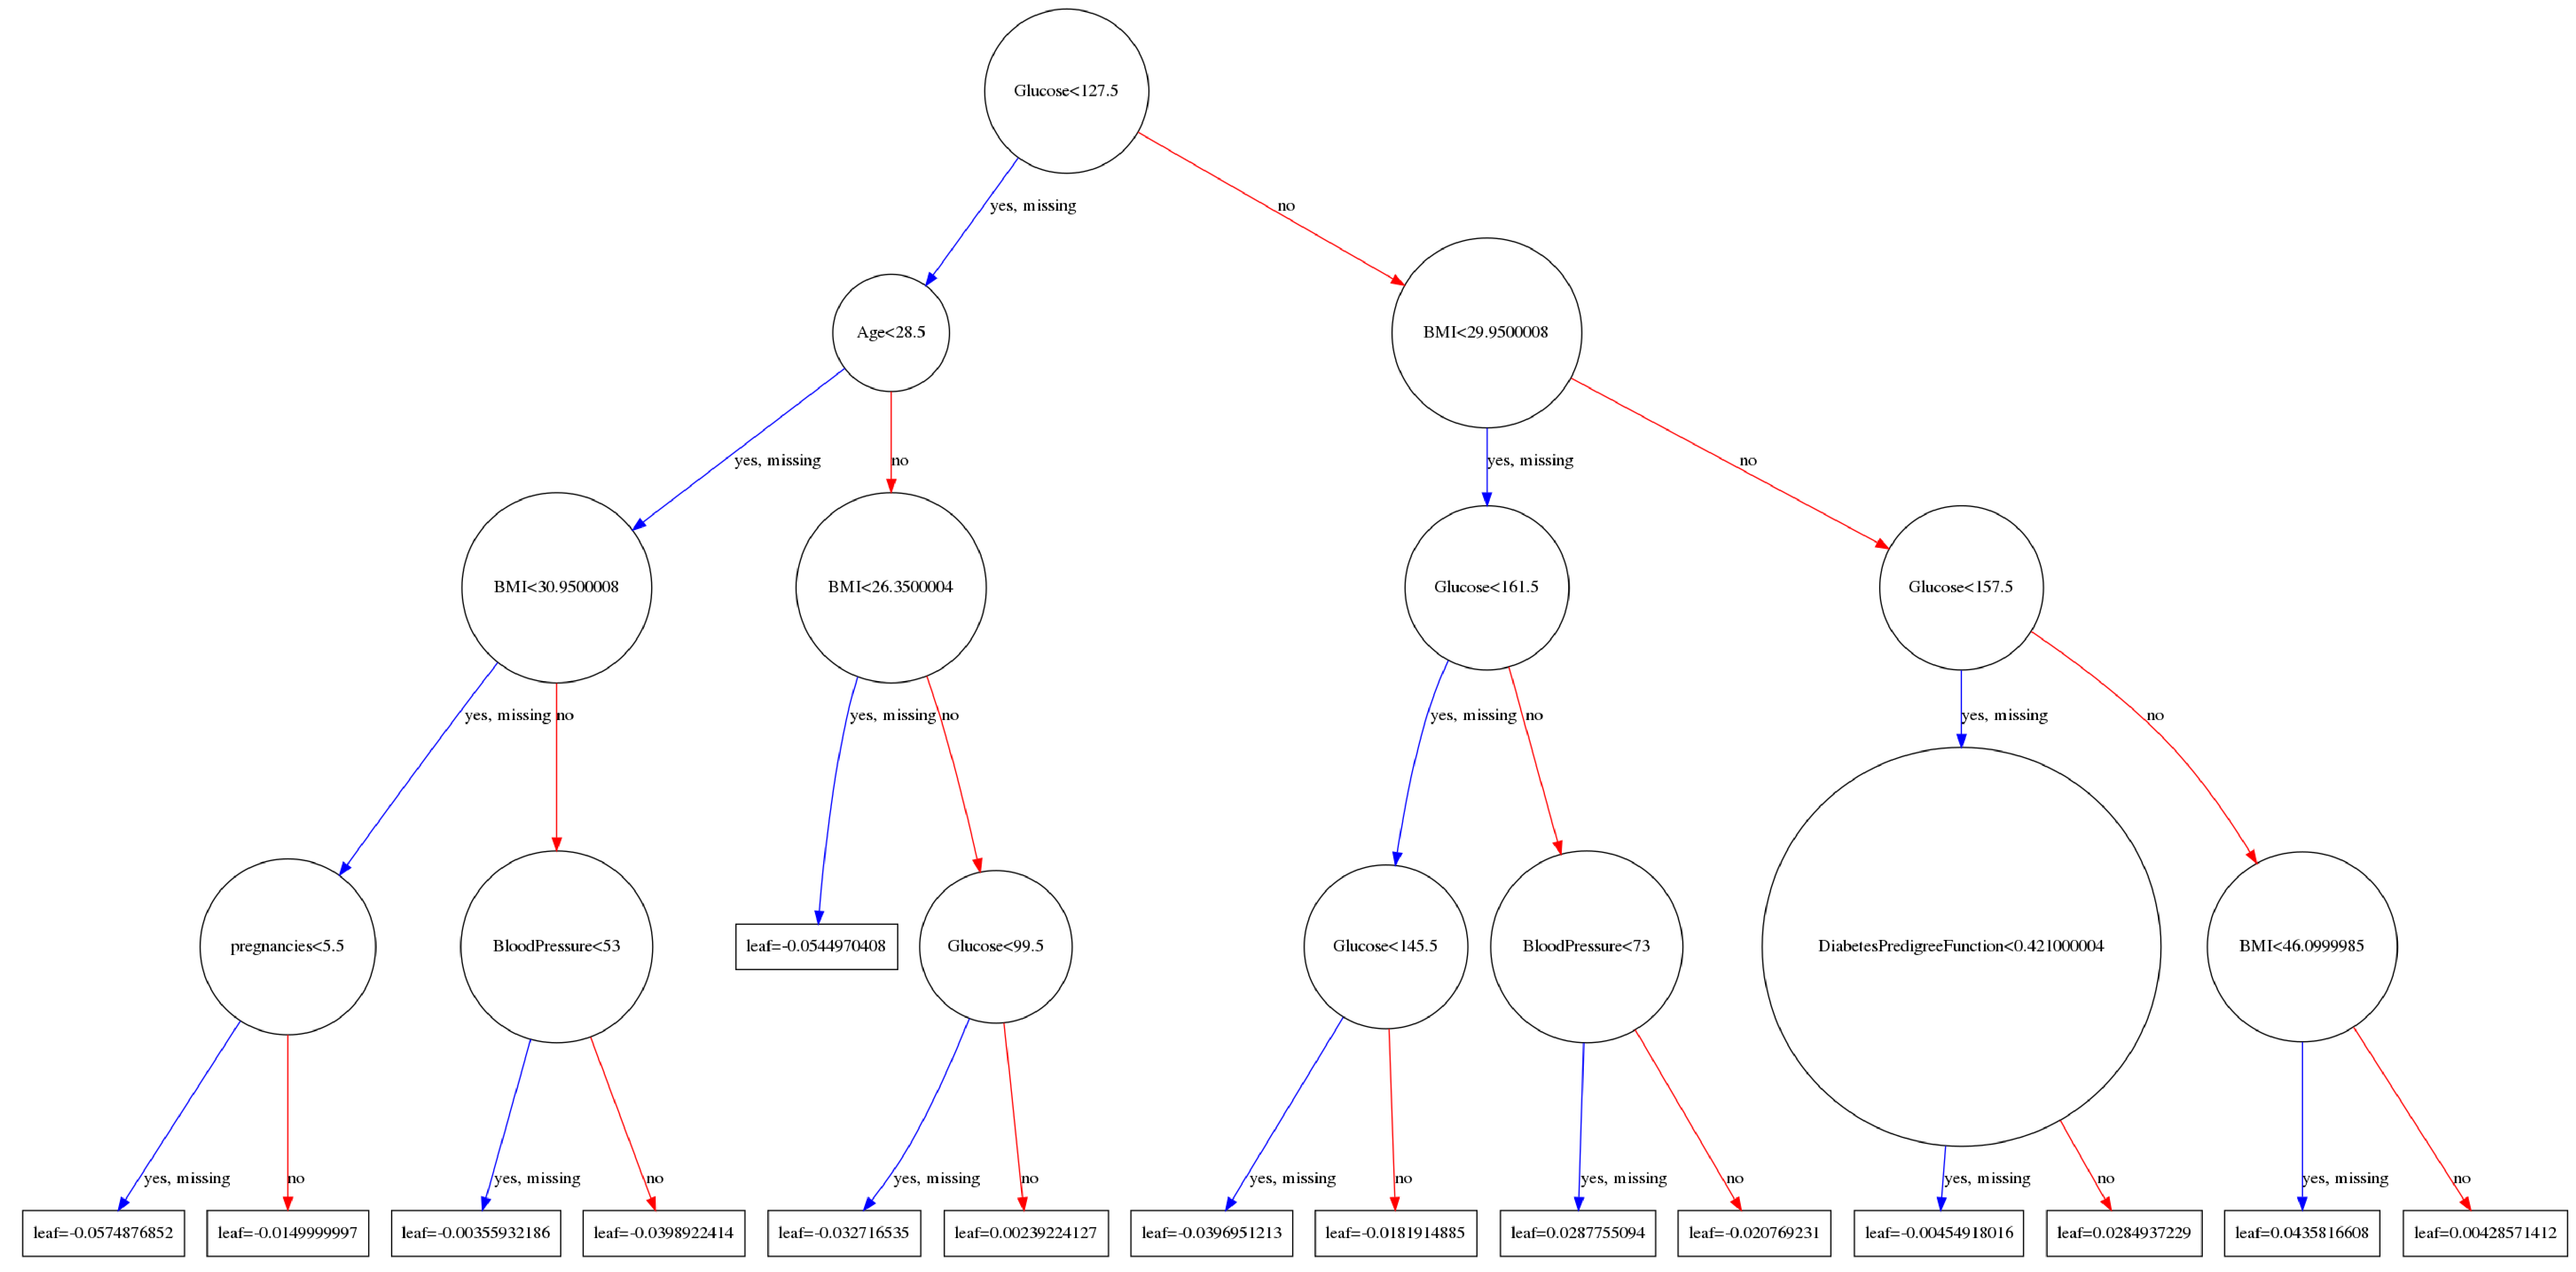

In [91]:
model = XGBClassifier(booster = 'gbtree',
                     objective = 'binary:logistic',
                     learning_rate=0.03,
                     n_estimators=150,
                     reg_alpha=0.15,
                     reg_lambda=0.7,
                     max_depth=4)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]

# 정확도 평가

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%"%(accuracy * 100.0))

# 시각화 하기
%matplotlib inline
from xgboost import plot_tree
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 100, 200

# 의사 결정 트리 시각화
plot_tree(model)
plt.show()

머신러닝 모델은 정확도나 정밀성, 재현도, 민감도, 특이성, 낙제율과 같은 다양한 기준에 의해 달라질 수 있다고 했다.

이때 모든 피처에 대한 계산은 컨퓨전 행렬(Confusion Matrix)을 사용해 찾아낼 수 있다.

In [92]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

[[88  9]
 [15 42]]


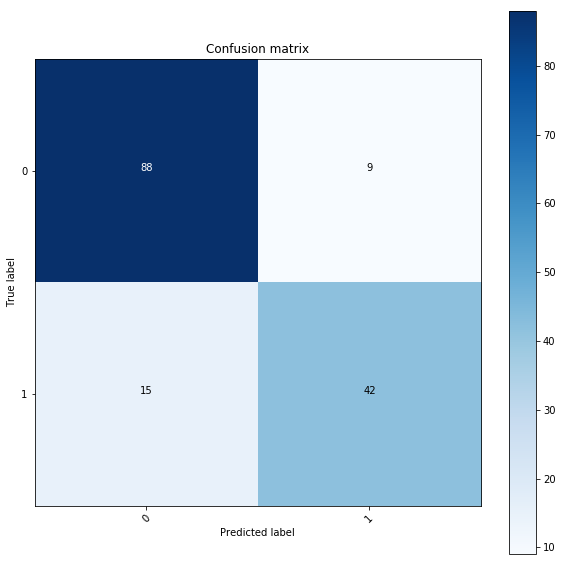

Precision=        0.824
Recall (TPR)=     0.737
Fallout (FPR)=    0.093


(0.8235294117647058, 0.7368421052631579, 0.09278350515463918)

In [99]:
import itertools

def plot_confusion_matrix(cm,
                         classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment='center',
                color='white' if cm[i,j] > thresh else "black")
    plt.ylabel("True label")
    plt.xlabel('Predicted label')
    plt.rcParams["figure.figsize"] = (10,10)
    plt.show()
    
def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        print("Precision=        {:.3f}".format(tp/(tp+fp)))
        print("Recall (TPR)=     {:.3f}".format(tp/(tp+fn)))
        print("Fallout (FPR)=    {:.3f}".format(fp/(fp+tn)))
    return tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)

plot_confusion_matrix(cm, ['0','1'],)
show_data(cm,print_res=1)

 모델은 재현도보다 정밀성이 높다.
 
 즉, 당뇨병이 있다고 진단했을 때 그 진단을 신뢰할 가능성이 82.4%이고,
 
 실제 당뇨환자 중에서 당뇨병 환자를 색출해낼 가능성은 73.7%인 모델이다.
 
 낙제율은 실제 당뇨병이 없는 환자들 중 모델이 당뇨가 있다고 진단한 비율이다(9.2%).
 
 특정 문제에서는 민감도가 중요할 것이고, 어떤 문제에서는 정밀성이 중요할 것이다.
 
 상황에 맞게 그것을 높이는 방향으로 모델을 구성하여 학습해야 한다.